## Recall concepts

Here a list of concepts you should recall for this exercises in order to solve them:
- **Neural network**: It consists of interconnected nodes, called artificial neurons or "units," organized in layers. By processing input data through these interconnected layers, a neural network can learn and make predictions or classifications based on patterns and relationships in the data.
- **Neurons and layers**: They are designed to perform simple computations. Each neuron takes input from other neurons or from the input data, applies a mathematical operation to the inputs, and produces an output.
Layers in a neural network are groups of neurons that are organized in a hierarchical manner. The input layer receives the initial data input, and the output layer produces the final output of the network. The hidden layers are intermediate layers between the input and output layers and perform complex computations on the input data
- **Activation functions**: An activation function is a mathematical function applied to the output of a neuron in a neural network. It introduces non-linearity to the network, enabling it to learn complex patterns and make more accurate predictions. Activation functions determine whether a neuron should be activated or not, based on the weighted sum of its inputs.
- **Loss functions**: A loss function, also known as a cost function or an objective function, is a mathematical function used to measure the discrepancy between the predicted output of a neural network and the expected output (ground truth). It quantifies the error or loss incurred by the network's predictions. The goal of the network during training is to minimize this loss function, effectively reducing the error and improving the accuracy of predictions.
- **Batches and batch size**: Batches enable simultaneous weight updates based on average errors within the batch. Batch size refers to the number of training examples processed together in a neural network. It allows large datasets to be divided into smaller subsets, making training more computationally efficient. 
- **SGD**: Stochastic Gradient Descent (SGD) is an optimization algorithm used in training. It works by iteratively updating the model's parameters (weights and biases) based on the gradients of the loss function computed on small random subsets of the training data called mini-batches. SGD allows the model to efficiently navigate the parameter space in search of the optimal values that minimize the loss function.
- **Backpropagation**: It involves computing and propagating gradients backward through the network to update the weights and biases. By comparing the network's predicted output with the expected output, backpropagation calculates the error and distributes it back through the layers, assigning each layer a portion of the error based on its contribution. This allows the network to adjust its weights in a way that reduces the overall error, enabling improved predictions.
- **Learning rate**: The learning rate is a hyperparameter in machine learning algorithms that controls the rate of parameter updates during training. It determines the step size for adjusting the weights and biases of the model. A higher learning rate can speed up convergence but risks overshooting the optimal solution. Conversely, a lower learning rate leads to slower convergence but can provide more stable learning.
- **Dropout**: Dropout is a regularization technique used in neural networks to reduce overfitting. It randomly "drops out" a fraction of the neurons during each training iteration, meaning they are temporarily ignored. This prevents neurons from relying too heavily on specific features, promoting the learning of more robust and independent representations.
- **Epochs**: An epoch is a complete pass through the training dataset. During an epoch, the model updates its parameters based on the training data. The number of epochs determines how many times the dataset is processed. It affects the model's learning and convergence. The optimal number of epochs is determined through experimentation.


##Some usefull clarifications about backpropagation
Backpropagation(more precisely Error's Backpropagation) is the process through which the model detect those neurons who gave the major contribution to the loss function.
To be clear, we want to identify those neurons whose activation causes most of the errors in order to adjust the weights connected to them with gradient descent based algotithms (optimizers).
After the forward pass in which the model if feeded and loss function is calculated we have a backward pass in wich backpropagation is involved.
During the backpropagation it is calculated a chain of partial gradients. These partial gradients are calculated by fixing some parametres (by fixing some neuron's weights -- remember that the weights are the loss function's parametres).
Calculating each possible gradient we cane understand who is the neurons whose weights are the most responsible for errors. Intuitively we can say that those weights will have the highest absolute value of the partial gradients.
These weights will be adjusted in someway by the optimizer. 



In [1]:
%matplotlib inline

import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

We can check whether we have GPUs available:

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    print("Change the options of this Notebook to use the GPU instead for a quicker execution and re-run the notebook!")
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## MNIST data set

Next we'll load the MNIST handwritten digits data set.  First time we may have to download the data, which can take a while.

#### Altenative: Fashion-MNIST
We will use it for the next experiment.
Alternatively, MNIST can be replaced with Fashion-MNIST, which can be used as drop-in replacement for MNIST.   Fashion-MNIST contains images of 10 fashion categories:

Label|Description|Label|Description
--- | --- |--- | ---
0|T-shirt/top|5|Sandal
1|Trouser|6|Shirt
2|Pullover|7|Sneaker
3|Dress|8|Bag
4|Coat|9|Ankle boot


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 9912422/9912422 [00:00<00:00, 194060479.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40663207.06it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 121915338.32it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17287231.19it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's take a closer look. Here are the first 20 training digits 

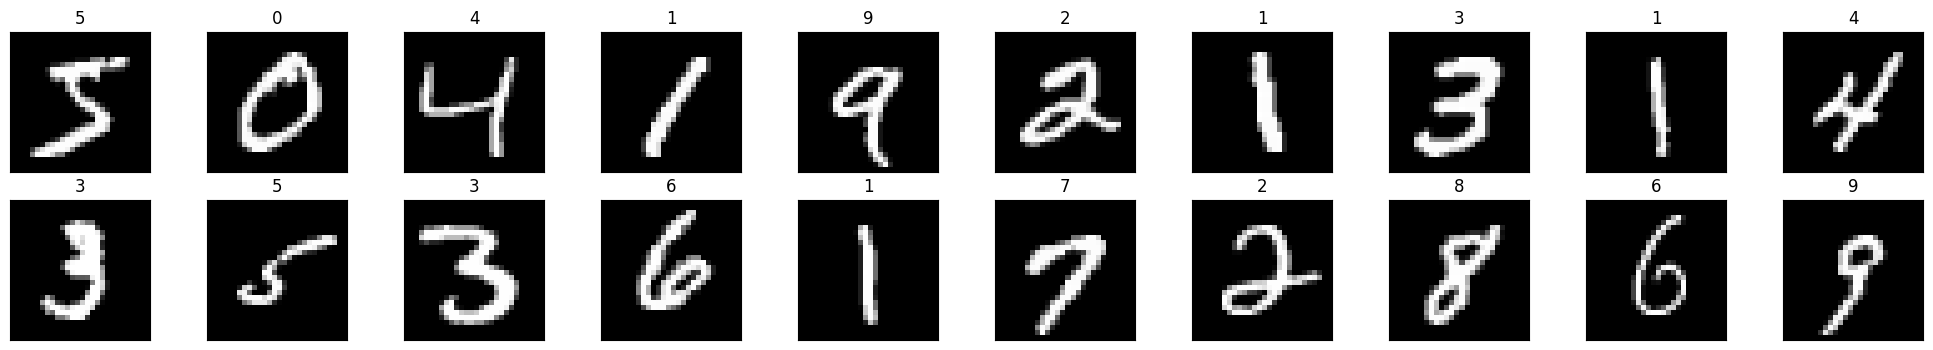

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

View an Image in More Detail

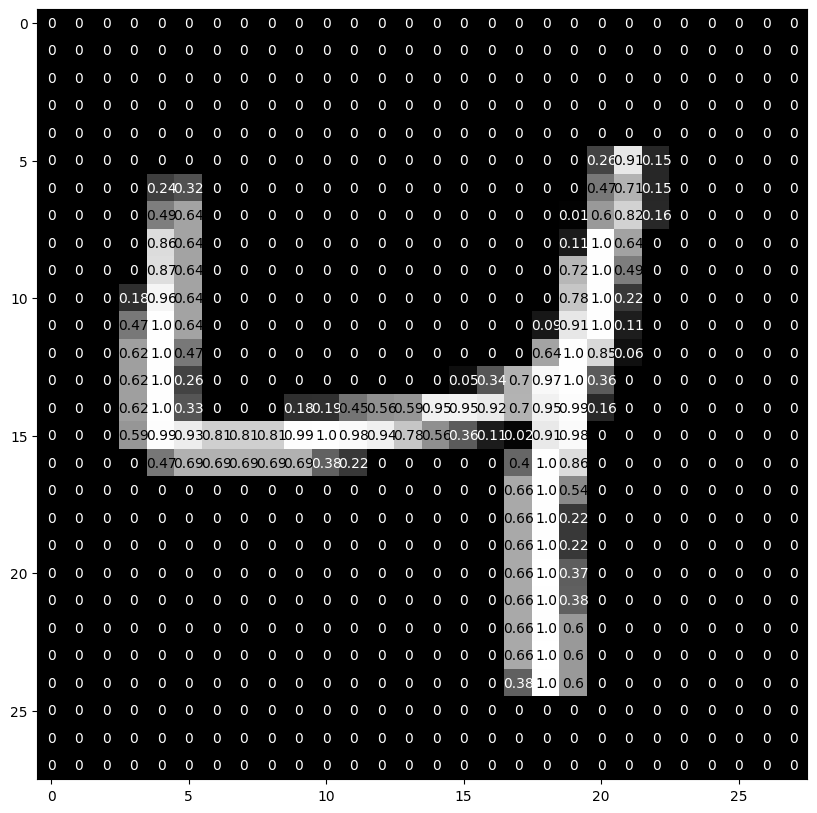

In [ ]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## "Linear" model

### Initialization

Let's begin with a simple linear model.  
We need to define a `Model` that implements the NeuralNetwork from Pytorch.  
Then we add a `Dense` layer that has 28*28=784 input nodes (one for each pixel in the input image) and 10 output nodes. The `Linear` layer connects each input to each output with some weight parameter. 


In [3]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)
    
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # we can apply dropout
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.fc(x)
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc): Linear(in_features=784, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


**Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)**

It's recommended that you use cross-entropy loss for classification. Here the softmax is not explicitly declared as the `CrossEntropyLoss`is expected to be directly applied to logits. (If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a Softmax function to the output layer and then calculates the log loss.)


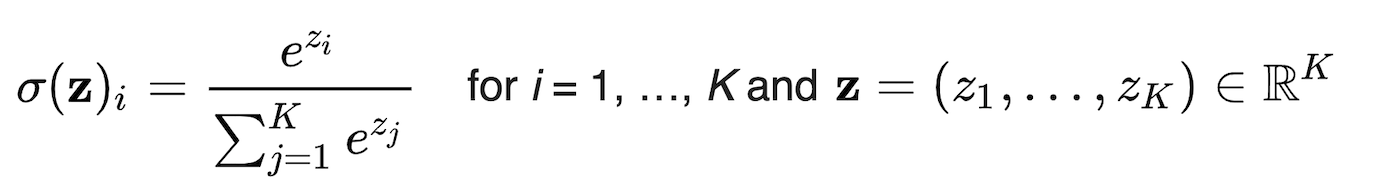


In [4]:
## Specify loss and optimization functions

# specify loss function. NOTE: it contains the softmax so it is not needed to 
# implement it in the network definition
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### Learning

Now we are ready to train our first model.  An *epoch* means one pass through the whole training data. 

The steps for training/learning from a batch of data are described in the comments below:

1.   Clear the gradients of all optimized variables
2.   Forward pass: compute predicted outputs by passing inputs to the model
3.   Calculate the loss between the predicted output and the expected output
4.   Backward pass: compute gradient of the loss with respect to model parameters
5.   Perform a single optimization step (parameter update)
6.   Update average training loss

The following loop trains for 10 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

##Some clarifications about gradient clearing
We can see in the next portion of code that (as explained in the steps above) that before performing the backward pass for each batch we clear the gradients obtained for the previous batch during the previous backward pass using optimizer.zero_grad().
Why we do that?
Note that in our model each gradient calculus is independent for each batch.
So for each batch we have an independent backward pass with independent gradients and so optimizers.
It is possible in some implementation to use the previous batches gradients for calculating the current one despite we have different batches.
This approach is called gradient accumulation and can be adopted for various reasons... like:
- our task consists in analyzing long sequences of data that cannot be contained in a single batch (we could augment the batch dimension but we would lose small batches advantages)
- use small batches in general because of limited storage (using gradient accumulation we are in someway reducing the independence between different batches)
- regularizing the weight's adjustement. If during training a model processes a batch containing exceptionally a large set of outliers the weights could be updated too strongly (we would have too high weight's variance between different batches). 

Since we could be in one of these cases or other , Pytorch's implementation includes by default the storage of the previous batch's gradients.

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad() #** CLARIFICATIONS ABOVE
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.790039
Epoch: 2 	Training Loss: 0.481358
Epoch: 3 	Training Loss: 0.433367
Epoch: 4 	Training Loss: 0.406927
Epoch: 5 	Training Loss: 0.391280
Epoch: 6 	Training Loss: 0.381667
Epoch: 7 	Training Loss: 0.372668
Epoch: 8 	Training Loss: 0.366637
Epoch: 9 	Training Loss: 0.361499
Epoch: 10 	Training Loss: 0.356329


## Inference

Finally, we test our best model on previously unseen test data and evaluate its performances

`model.eval()` will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.307578

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1102/1135)
Test Accuracy of     2: 86% (896/1032)
Test Accuracy of     3: 90% (912/1010)
Test Accuracy of     4: 92% (909/982)
Test Accuracy of     5: 86% (774/892)
Test Accuracy of     6: 94% (909/958)
Test Accuracy of     7: 91% (936/1028)
Test Accuracy of     8: 89% (867/974)
Test Accuracy of     9: 89% (904/1009)

Test Accuracy (Overall): 91% (9171/10000)


Here are the first 20 test digits the linear model classified, with the incorrect classification are in red

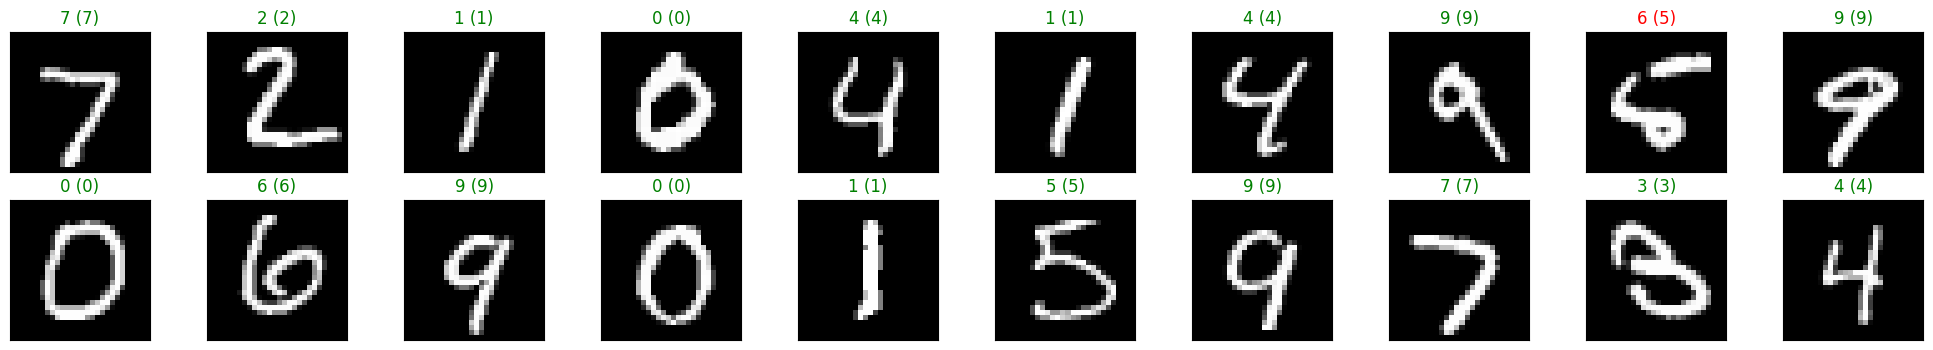

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

## Exercise 1

Train the same model using the Fashion-MNIST (introduced at the beginning of this Notebook) dataset and try to optimize its performance.

Load the Fashion-MNIST dataset...

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 26421880/26421880 [00:01<00:00, 16098574.70it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274177.28it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4992633.95it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6883097.54it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



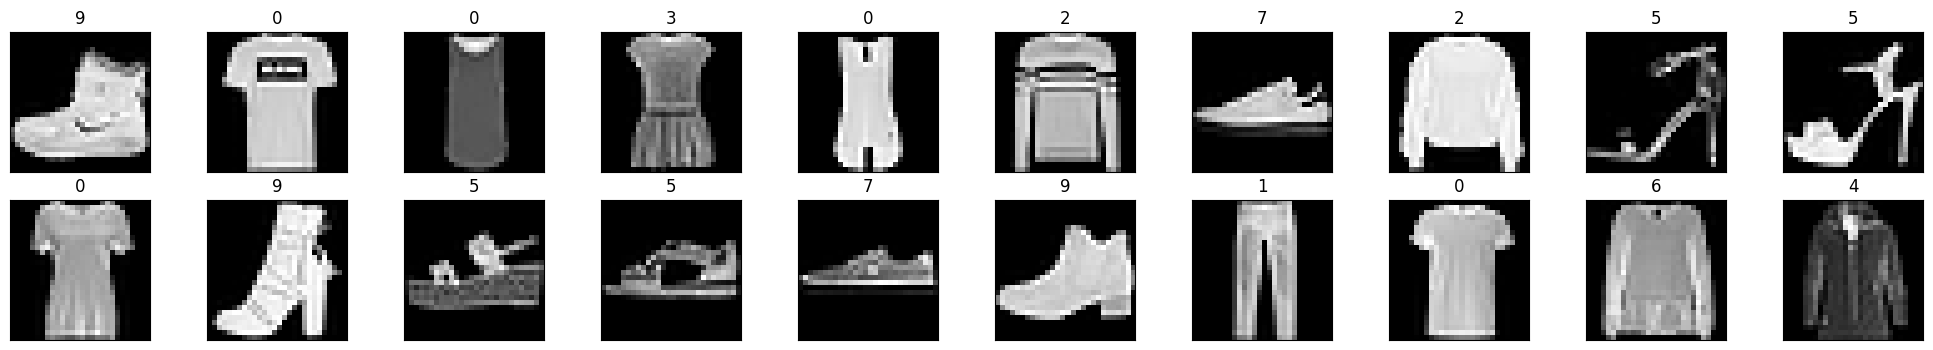

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

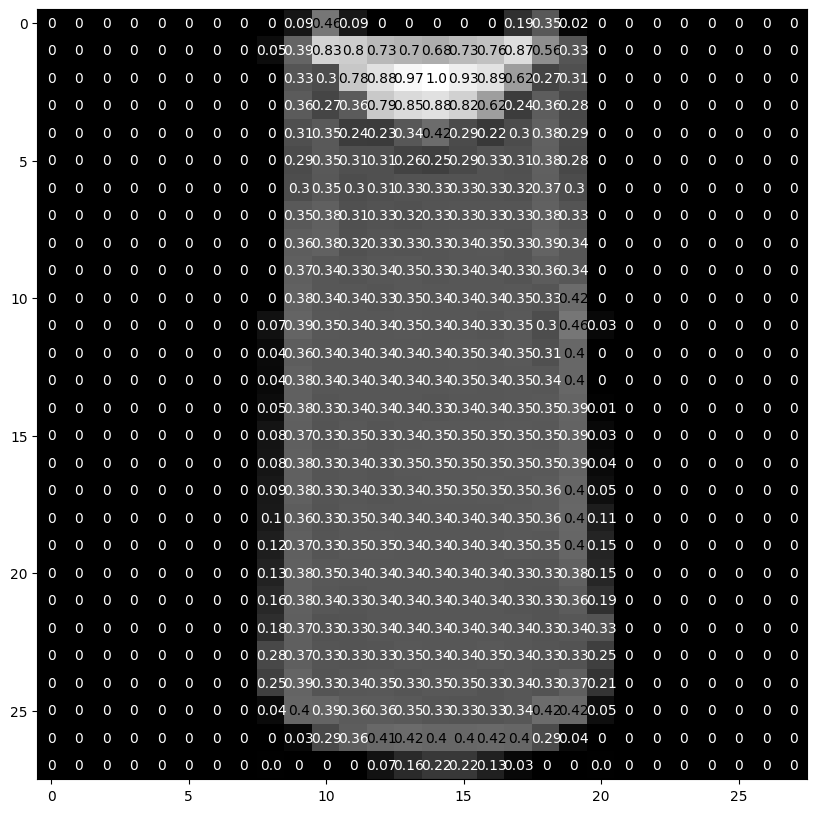

In [ ]:
img = np.squeeze(images[2])

fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

Define and initialise the model. The model will have the same hyperparametres of the previous one since MNIST's and FashionMNIST's elements have the same number of features (in fact they are both matrices 28*28) 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28 * 28, 10)
    
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # we can apply dropout
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.fc(x)
        
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc): Linear(in_features=784, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Define the loss function and the optimizer...

In [ ]:
## Specify loss and optimization functions

# specify loss function. NOTE: it contains the softmax so it is not needed to 
# implement it in the network definition
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

Train the model for 10 epochs...

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad() #** CLARIFICATIONS ABOVE
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32])
torch.Size([32

KeyboardInterrupt: ignored

Test the obtained model on the test set and evaluate it...

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.490185

Test Accuracy of     0: 83% (831/1000)
Test Accuracy of     1: 94% (944/1000)
Test Accuracy of     2: 72% (721/1000)
Test Accuracy of     3: 86% (867/1000)
Test Accuracy of     4: 78% (783/1000)
Test Accuracy of     5: 88% (887/1000)
Test Accuracy of     6: 49% (498/1000)
Test Accuracy of     7: 90% (904/1000)
Test Accuracy of     8: 94% (946/1000)
Test Accuracy of     9: 95% (951/1000)

Test Accuracy (Overall): 83% (8332/10000)


Looking at the overall accuracy obtained by the model on two tasks, we can see that it performs better on the first one (Digit Recognition) .  

## Multi-layer perceptron (MLP) network

### Activation functions

Let's start by plotting some common activation functions for neural networks. `'relu'` stands for rectified linear unit, $y=\max(0,x)$, a very simple non-linearity we will be using in our MLP network below. A more recent and interesting activation function is `'gelu'`, that stands for 'GAUSSIAN ERROR LINEAR UNIT'. It will not be used here but keep it in mind as it can be very usefull for your exercises!

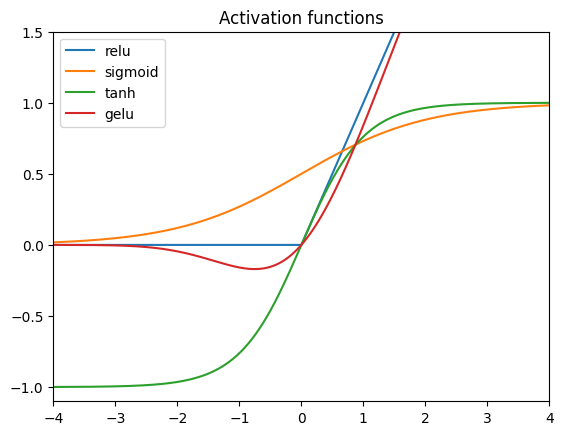

In [ ]:
x = np.arange(-4,4,.01)
plt.figure()
plt.plot(x, np.maximum(x,0), label='relu')
plt.plot(x, 1/(1+np.exp(-x)), label='sigmoid')
plt.plot(x, np.tanh(x), label='tanh')
plt.plot(x, x * (0.5 * (1.0 + np.tanh((np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3)))))), label="gelu")
plt.axis([-4, 4, -1.1, 1.5])
plt.title('Activation functions')
plt.legend(loc='best');

### Initialization

Let's now create a more complex MLP model that has multiple layers, non-linear activation functions, and dropout layers.  `Dropout()` randomly sets a fraction of inputs to zero during training, which is one approach to regularization and can sometimes help to prevent overfitting.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 20)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(20, 20)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(20, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

        self.relu = F.relu

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = self.fc3(self.dropout(self.relu(self.fc2(self.relu(self.fc1(x))))))
        return x

# initialize the NN
model2 = MLP()
print(model2)

MLP(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Learning
*IMPORTANT*: since the model is changed, the Optimizer **MUST** be updated with the parameters of the new model.

*WARNING*: we are going to train and test the model on the second task.
train_loader and test_loader contain matrices representing fashion items (FashionMNIST dataset).

In [ ]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01)

Let's train the model on FashionMNIST train_set for 10 epochs...

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model2.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer2.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model2(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer2.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.355917
Epoch: 2 	Training Loss: 0.775228
Epoch: 3 	Training Loss: 0.672864
Epoch: 4 	Training Loss: 0.617852
Epoch: 5 	Training Loss: 0.588128
Epoch: 6 	Training Loss: 0.570772
Epoch: 7 	Training Loss: 0.550908
Epoch: 8 	Training Loss: 0.537422
Epoch: 9 	Training Loss: 0.530161
Epoch: 10 	Training Loss: 0.520075


### Inference

Accuracy for test data.  The model should be somewhat better than the linear model. 

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model2.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model2(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.473030

Test Accuracy of     0: 79% (790/1000)
Test Accuracy of     1: 95% (950/1000)
Test Accuracy of     2: 73% (730/1000)
Test Accuracy of     3: 89% (891/1000)
Test Accuracy of     4: 82% (825/1000)
Test Accuracy of     5: 88% (887/1000)
Test Accuracy of     6: 42% (421/1000)
Test Accuracy of     7: 94% (941/1000)
Test Accuracy of     8: 93% (937/1000)
Test Accuracy of     9: 94% (945/1000)

Test Accuracy (Overall): 83% (8317/10000)


Looking at the results obtained we can see that despite we have added a layer to the model the overall accuracy obtained is nearly the same. 

Here are the first 20 test digits the MLP classified to a wrong class:

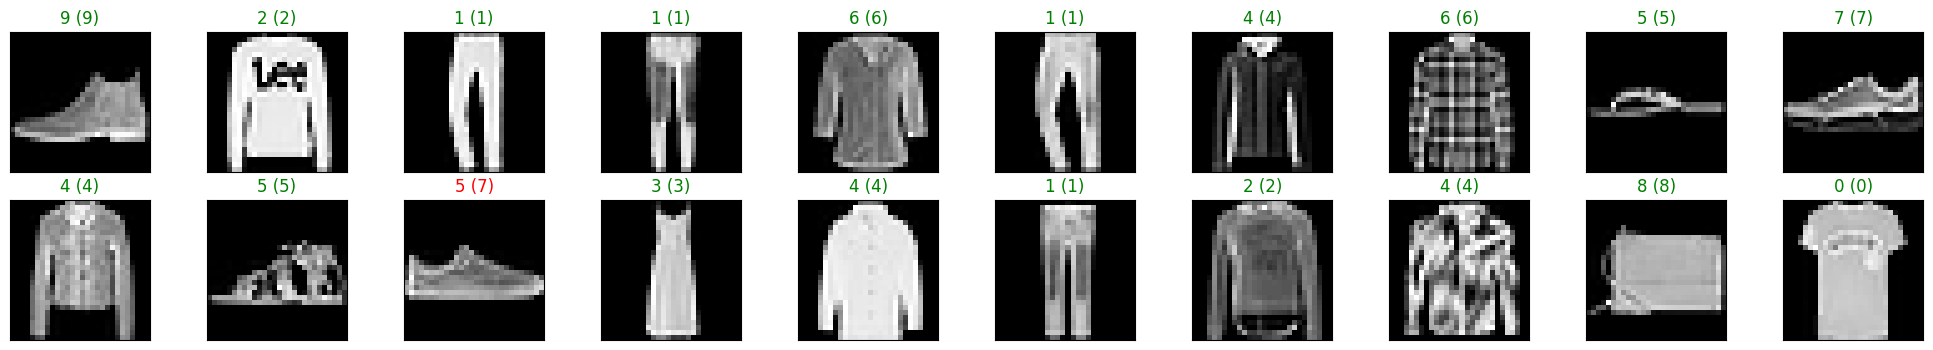

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Exercise 2

Design and implement an MLP (for example, with 2 hidden layers and 2-4 neurons for each layer) for the Question Classification dataset. You should already have the dataset saved on your pc!  
Create 2 networks:
- using the BoW representation for the questions;
- using the Neural Encoding from sBERT shown in previous exercises;

The train the network and evaluate it maximizing the resulting F1-score.


**Hints**: 
- Upload the dataset files on the colab machine in order to access them.
- The input layer needs to be equal to the number of features:  
  - BoW representations has 11.000 features? You need 11.000 input neurons.  
  - sBERT representation has 768 features? You need 768 neurons!
- The output layer needs to be same size as the number of total classes.
- In order to maximize the F1-score, you should tweak some hyperparameters such as: `learning_rate`, `dropout`, number of `layers`/`neurons`, `activation function`, `loss function`, number of `epochs`, ..

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [6]:
# option to print all the value of cells in DataFrames
pd.set_option("max_colwidth", None)

In [8]:
training_data = pd.read_csv("./train.csv")
testing_data = pd.read_csv("./test.csv")

Get the TF-IDF Vectorization for each element of the train_set and test_set...

In [ ]:
# Extract features from the dataset
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(training_data['questions'].tolist()).toarray()
X_test = vectorizer.transform(testing_data['questions'].tolist()).toarray()

Transform target's list into a number's np.array list by mapping the set of classes to a set of related numbers...

In [9]:
Y_train=np.empty(len(training_data))
Y_test=np.empty(len(testing_data))

classes=training_data["classes"].unique() #lista/insieme degli autori

print(classes)

training_targets=np.array(training_data["classes"])
testing_targets=np.array(testing_data["classes"])

for i in range (len(training_data)):
  Y_train[i]=np.where(classes == training_targets[i])[0][0]

for i in range (len(testing_data)):
  Y_test[i]=np.where(classes == testing_targets[i])[0][0]

Y_train=Y_train.astype("int")
Y_test=Y_test.astype("int")

['DESC' 'ENTY' 'ABBR' 'HUM' 'NUM' 'LOC']


Transforming numpy's array in pytorch tensors...

In [ ]:
import torch

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()

X_test = torch.from_numpy(X_test).float()
Y_test = torch.from_numpy(Y_test).long()

NOTE that we have only 5452 examples ... while in the previous tasks we had 60k examples

In [ ]:
print(X_train.shape)
print(Y_train.shape)

torch.Size([5452, 8410])
torch.Size([5452])


Load the data inside a tensor dataset splitting them into 32 different batches...

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# how many samples per batch to load
batch_size = 32

train_data = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)


In [ ]:
input_dim = len(X_train[0])  #len(X_train[0]) == number of features for each datum == len of vocabulary 
output_dim = len(classes)

#Some usefull clarifications about training and epochs

An epoch represents a complete pass of the entire training dataset through the model, divided into batches. Seeing the same data more than one times could be usefull for the model for understanding whether the weight's adjustment is going well.
Here are some considerations about number of epochs: 

*Few Epochs and Poor Training:* If only a few epochs are performed during training, the model may not learn effectively or may fail to adjust its weights optimally. Insufficient training can lead to underfitting, where the model doesn't capture the patterns and complexities present in the data.

*Too Many Epochs and Overfitting:* On the other hand, if too many epochs are performed, the model may risk overfitting. Overfitting occurs when the model becomes excessively tailored to the training dataset and loses its ability to generalize to unseen data. The model starts memorizing the training examples instead of learning meaningful patterns, resulting in poor performance on new data.

It is crucial to strike a balance and determine an optimal number of epochs during training to ensure the model learns the underlying patterns without overfitting. Techniques such as early stopping, regularization (gradients clearing, dropout...), and cross-validation can help prevent overfitting and find the right number of epochs for a given task.

#MODEL 4
Let's define a simple model consisting in an input layer with input_dim (dimension of vocabulary) number of neurons and an output layer with output_dim (6 classes) number of neurons.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, input_dim)
        # we can apply dropout
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.fc(x)
        
        return x

# initialize the NN
model4 = Net()
print(model4)

Net(
  (fc): Linear(in_features=8410, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Redefining the optimizer...

Remember the loss function is the Cross Entropy as defined above...

In [ ]:
optimizer4 = torch.optim.SGD(model4.parameters(), lr=0.01)

#Some usefull clarifications about training and epochs

An epoch represents a complete pass of the entire training dataset through the model, divided into batches. Seeing the same data more than one times could be usefull for the model for understanding whether the weight's adjustment is going well.
Here are some considerations about number of epochs: 

*Few Epochs and Poor Training:* If only a few epochs are performed during training, the model may not learn effectively or may fail to adjust its weights optimally. Insufficient training can lead to underfitting, where the model doesn't capture the patterns and complexities present in the data.

*Too Many Epochs and Overfitting:* On the other hand, if too many epochs are performed, the model may risk overfitting. Overfitting occurs when the model becomes excessively tailored to the training dataset and loses its ability to generalize to unseen data. The model starts memorizing the training examples instead of learning meaningful patterns, resulting in poor performance on new data.

It is crucial to strike a balance and determine an optimal number of epochs during training to ensure the model learns the underlying patterns without overfitting. Techniques such as early stopping, regularization (gradients clearing, dropout...), and cross-validation can help prevent overfitting and find the right number of epochs for a given task.

Train the linear model for 40 epochs ...

In [ ]:
# number of epochs to train the model
n_epochs = 40  # suggest training between 20-50 epochs

model4.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        optimizer4.zero_grad() #NOTE we don't clear the gradient
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model4(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer4.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.766230
Epoch: 2 	Training Loss: 1.729444
Epoch: 3 	Training Loss: 1.705240
Epoch: 4 	Training Loss: 1.688173
Epoch: 5 	Training Loss: 1.675335
Epoch: 6 	Training Loss: 1.665250
Epoch: 7 	Training Loss: 1.656743
Epoch: 8 	Training Loss: 1.649629
Epoch: 9 	Training Loss: 1.643171
Epoch: 10 	Training Loss: 1.638046
Epoch: 11 	Training Loss: 1.632784
Epoch: 12 	Training Loss: 1.627836
Epoch: 13 	Training Loss: 1.623517
Epoch: 14 	Training Loss: 1.618644
Epoch: 15 	Training Loss: 1.615092
Epoch: 16 	Training Loss: 1.611146
Epoch: 17 	Training Loss: 1.607072
Epoch: 18 	Training Loss: 1.603470
Epoch: 19 	Training Loss: 1.599492
Epoch: 20 	Training Loss: 1.596583
Epoch: 21 	Training Loss: 1.592187
Epoch: 22 	Training Loss: 1.588641
Epoch: 23 	Training Loss: 1.586465
Epoch: 24 	Training Loss: 1.582954
Epoch: 25 	Training Loss: 1.579946
Epoch: 26 	Training Loss: 1.575884
Epoch: 27 	Training Loss: 1.571869
Epoch: 28 	Training Loss: 1.570290
Epoch: 29 	Training Loss: 1.5

Evaluate it on the test set...

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model4.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model4(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.518705

Test Accuracy of     0: 66% (92/138)
Test Accuracy of     1: 87% (82/94)
Test Accuracy of     2:  0% ( 0/ 9)
Test Accuracy of     3: 83% (54/65)
Test Accuracy of     4:  6% ( 7/113)
Test Accuracy of     5: 11% ( 9/81)

Test Accuracy (Overall): 48% (244/500)


The marginal accuracy is very low (especially for some classes like the 2nd which has only 9 samples) and as a consequence the overall accuracy is very low.


In [ ]:
training_data.groupby(["classes"]).count()

,questions
classes,
ABBR,86
DESC,1162
ENTY,1250
HUM,1223
LOC,835
NUM,896


In [ ]:
testing_data.groupby(["classes"]).count()

,questions
classes,
ABBR,9
DESC,138
ENTY,94
HUM,65
LOC,81
NUM,113


Looking at training data classes distribution we can see that we have too few examples for some kind (like ABBR questions...).
We could try to add an hidden layer to the model in order to get the model to learn more patterns living inside the data... (but probably this is not going to solve the problem of data unbalancing and scarsity...)

#MODEL 5
Let's add an hidden layer to the previous model.

This new hidden layer has 10k neurons.

Activation Function,Droupout,Optimizer,Loss Function are the same as before.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10000)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(10000, output_dim)
        # linear layer (n_hidden -> 10)
        #self.fc3 = nn.Linear(20, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.4)

        self.relu = F.relu

    def forward(self, x):
        # flatten image input
        x = x.view(-1, input_dim)
        # add hidden layer, with relu activation function
        #x = self.fc2(self.dropout(self.relu(self.fc1(x))))
        x = self.fc2(self.relu(self.fc1(x)))
        return x

# initialize the NN
model5 = MLP()
print(model5)

MLP(
  (fc1): Linear(in_features=8410, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=6, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


Redefining the optimizer...

Remember the loss function is the Cross Entropy as defined above...

In [ ]:
optimizer5 = torch.optim.SGD(model5.parameters(), lr=0.01)

Let's train the model for 10 epochs

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model5.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        optimizer5.zero_grad() 
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model5(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer5.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.762236
Epoch: 2 	Training Loss: 1.721175
Epoch: 3 	Training Loss: 1.697410
Epoch: 4 	Training Loss: 1.682358
Epoch: 5 	Training Loss: 1.672167
Epoch: 6 	Training Loss: 1.664661
Epoch: 7 	Training Loss: 1.658997
Epoch: 8 	Training Loss: 1.654466
Epoch: 9 	Training Loss: 1.650714
Epoch: 10 	Training Loss: 1.647455


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model5.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model5(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.672905

Test Accuracy of     0:  0% ( 0/138)
Test Accuracy of     1: 100% (94/94)
Test Accuracy of     2:  0% ( 0/ 9)
Test Accuracy of     3: 73% (48/65)
Test Accuracy of     4:  0% ( 0/113)
Test Accuracy of     5:  0% ( 0/81)

Test Accuracy (Overall): 28% (142/500)


Marginal and Overall Accuracy are worse than in the previous model...

Since we have too few examples an interest experiment could consists in accumulating the gradient during the training phase. Due to this approach batches gradient won't be independent but will be connected one to another since the gradient on the current one is used for calculating the gradient of the next one...

Redefining the optimizer...

Remember the loss function is the Cross Entropy as defined above...

In [ ]:
optimizer5 = torch.optim.SGD(model5.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model5.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        #optimizer5.zero_grad() #NOTE WE DON'T CLEAR THE GRADIENT FROM ONE BATCH CALCULUS TO ANOTHER
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model5(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer5.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.571610
Epoch: 2 	Training Loss: 0.851995
Epoch: 3 	Training Loss: 0.477111
Epoch: 4 	Training Loss: 0.333735
Epoch: 5 	Training Loss: 0.300432
Epoch: 6 	Training Loss: 0.186150
Epoch: 7 	Training Loss: 0.143337
Epoch: 8 	Training Loss: 0.241455
Epoch: 9 	Training Loss: 0.306635
Epoch: 10 	Training Loss: 0.192466


In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model5.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model5(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 3.792406

Test Accuracy of     0: 78% (108/138)
Test Accuracy of     1: 89% (84/94)
Test Accuracy of     2: 77% ( 7/ 9)
Test Accuracy of     3: 84% (55/65)
Test Accuracy of     4: 91% (103/113)
Test Accuracy of     5: 79% (64/81)

Test Accuracy (Overall): 84% (421/500)


Marginal and Overall accuracy get better than in the previous model.

#Possible Interpretation
 Due to data unbalancing it happens often that in several batches there are not examples for each class. 
 
Gradient Accumulation counteracts this issue since optimizer adjusts weights at each batch-step considering also examples seen in previous batch-steps.

Now let's feed the model with bert-encoded data...

In [12]:
columns = ['bert_embedding']

bert_training_data = pd.read_csv("./train_embeddings_sbert.txt",header=None,names=columns)
bert_testing_data = pd.read_csv("./test_embeddings_sbert.txt",header=None,names=columns)

In [29]:
#inside the df we have strings of symbols representing float numbers for each question like {"0.2383 -0.23232 0.32323 ...","0.1187 -0.2785 0.523 ...",...}
#we need an array of arrays of questions embedding
#so we need to convert strings into arrays like [[0.2383,-0.23232,0.32323,...],[0.1187,-0.2785,0.523,...],...]

X_train = []

for emb in bert_training_data["bert_embedding"].tolist(): 
  question_vector = [float(value) for value in emb.split()]
  X_train.append(question_vector)

X_train = np.array(X_train) #for dataloader we need numpy array

X_test = []

for emb in bert_testing_data["bert_embedding"].tolist():
  question_vector = [float(value) for value in emb.split()]
  X_test.append(question_vector)

X_test = np.array(X_test)

In [32]:
import torch

#NOTE Y_train and Y_test are the same as before since targets have not changed

X_train = torch.from_numpy(X_train).float()
Y_train = torch.from_numpy(Y_train).long()

X_test = torch.from_numpy(X_test).float() 
Y_test = torch.from_numpy(Y_test).long() 

In [33]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# how many samples per batch to load
batch_size = 32

train_data = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [34]:
input_dim = len(X_train[0])  #len(X_train[0]) == number of features for each datum == tokens embedding in bert ---> 768  
output_dim = len(classes)

#MODEL 6
This model will be the same as MODEL 4 but input layer has 768 neurons...

In [36]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
    
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, input_dim)
        # we can apply dropout
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = self.fc(x)
        
        return x

# initialize the NN
model6 = Net()
print(model6)

Net(
  (fc): Linear(in_features=768, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [37]:
optimizer6 = torch.optim.SGD(model6.parameters(), lr=0.01)

Hyperparametres are the same as for Model4 ...

Train the model for 40 epochs...

In [38]:
# number of epochs to train the model
n_epochs = 40  # suggest training between 20-50 epochs

model6.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        optimizer6.zero_grad() #NOTE we don't clear the gradient
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model6(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer6.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.211812
Epoch: 2 	Training Loss: 0.797891
Epoch: 3 	Training Loss: 0.682331
Epoch: 4 	Training Loss: 0.623571
Epoch: 5 	Training Loss: 0.591124
Epoch: 6 	Training Loss: 0.559326
Epoch: 7 	Training Loss: 0.536590
Epoch: 8 	Training Loss: 0.517123
Epoch: 9 	Training Loss: 0.501218
Epoch: 10 	Training Loss: 0.490274
Epoch: 11 	Training Loss: 0.478981
Epoch: 12 	Training Loss: 0.467745
Epoch: 13 	Training Loss: 0.462172
Epoch: 14 	Training Loss: 0.451623
Epoch: 15 	Training Loss: 0.451684
Epoch: 16 	Training Loss: 0.442569
Epoch: 17 	Training Loss: 0.438488
Epoch: 18 	Training Loss: 0.436122
Epoch: 19 	Training Loss: 0.425953
Epoch: 20 	Training Loss: 0.428539
Epoch: 21 	Training Loss: 0.414698
Epoch: 22 	Training Loss: 0.415673
Epoch: 23 	Training Loss: 0.409887
Epoch: 24 	Training Loss: 0.406636
Epoch: 25 	Training Loss: 0.402674
Epoch: 26 	Training Loss: 0.396785
Epoch: 27 	Training Loss: 0.397417
Epoch: 28 	Training Loss: 0.390642
Epoch: 29 	Training Loss: 0.3

In [40]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model6.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model6(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.290563

Test Accuracy of     0: 95% (132/138)
Test Accuracy of     1: 81% (77/94)
Test Accuracy of     2: 88% ( 8/ 9)
Test Accuracy of     3: 93% (61/65)
Test Accuracy of     4: 96% (109/113)
Test Accuracy of     5: 91% (74/81)

Test Accuracy (Overall): 92% (461/500)


#Considerations

Marginal and Overall Accuracy on test set increased very significantly.

Bert Embedding considers only 768 features vs TFIDF Embedding that considers more than 8k features.

This means that the major of TFIDF embedding features are useless. 


#MODEL 7
This model will be the same as MODEL 5 but input layer has 768 neurons...

In [41]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 10000)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(10000, output_dim)
        # linear layer (n_hidden -> 10)
        #self.fc3 = nn.Linear(20, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.4)

        self.relu = F.relu

    def forward(self, x):
        # flatten image input
        x = x.view(-1, input_dim)
        # add hidden layer, with relu activation function
        #x = self.fc2(self.dropout(self.relu(self.fc1(x))))
        x = self.fc2(self.relu(self.fc1(x)))
        return x

# initialize the NN
model7 = MLP()
print(model7)

MLP(
  (fc1): Linear(in_features=768, out_features=10000, bias=True)
  (fc2): Linear(in_features=10000, out_features=6, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


In [42]:
optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.01)

Same Hyperparametres as for model 5

In [43]:
# number of epochs to train the model
n_epochs = 10  # suggest training between 20-50 epochs

model7.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        optimizer7.zero_grad() 
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model7(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer7.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 1.067928
Epoch: 2 	Training Loss: 0.670650
Epoch: 3 	Training Loss: 0.553964
Epoch: 4 	Training Loss: 0.488068
Epoch: 5 	Training Loss: 0.439365
Epoch: 6 	Training Loss: 0.403290
Epoch: 7 	Training Loss: 0.370806
Epoch: 8 	Training Loss: 0.345031
Epoch: 9 	Training Loss: 0.319999
Epoch: 10 	Training Loss: 0.298622


In [44]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model7.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model7(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.296399

Test Accuracy of     0: 97% (134/138)
Test Accuracy of     1: 74% (70/94)
Test Accuracy of     2: 88% ( 8/ 9)
Test Accuracy of     3: 93% (61/65)
Test Accuracy of     4: 96% (109/113)
Test Accuracy of     5: 91% (74/81)

Test Accuracy (Overall): 91% (456/500)


#Considerations

Performances on test set continues to be better than using TfIdf Embeddings.

With respect to the linear network (model6) performances do not seem to be better.

We can try to feed the model for 5 epochs more and see the results.

In [45]:
optimizer7 = torch.optim.SGD(model7.parameters(), lr=0.01)  #Reinitialize the optimizer

In [46]:
# number of epochs to train the model
n_epochs = 15  # suggest training between 20-50 epochs

model7.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_dataloader:
        #target = target.argmax(dim=1)
        # clear the gradients of all optimized variables
        optimizer7.zero_grad() 
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model7(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer7.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_dataloader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))


Epoch: 1 	Training Loss: 0.279437
Epoch: 2 	Training Loss: 0.260901
Epoch: 3 	Training Loss: 0.244008
Epoch: 4 	Training Loss: 0.228991
Epoch: 5 	Training Loss: 0.214646
Epoch: 6 	Training Loss: 0.201381
Epoch: 7 	Training Loss: 0.188761
Epoch: 8 	Training Loss: 0.177117
Epoch: 9 	Training Loss: 0.166382
Epoch: 10 	Training Loss: 0.155980
Epoch: 11 	Training Loss: 0.146896
Epoch: 12 	Training Loss: 0.137874
Epoch: 13 	Training Loss: 0.129822
Epoch: 14 	Training Loss: 0.122073
Epoch: 15 	Training Loss: 0.114825


In [47]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

model7.eval() # prep model for *evaluation*

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model7(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.238702

Test Accuracy of     0: 97% (135/138)
Test Accuracy of     1: 86% (81/94)
Test Accuracy of     2: 88% ( 8/ 9)
Test Accuracy of     3: 93% (61/65)
Test Accuracy of     4: 96% (109/113)
Test Accuracy of     5: 90% (73/81)

Test Accuracy (Overall): 93% (467/500)


Performances are getting a few better but we are not going to augment epochs since we can fall into overfitting...